FCPGTools V2 Demo Notebook
===========================

**Key Improvements:**
* Supports file read in from remote-servers via `xarray.open_dataset()` (i.e. [THREDDS](https://www.ncei.noaa.gov/access/thredds-user-guide)).
* Multi-dimensional paramater grid support (i.e. precipitation over time).
* In-memory objects -> no more unnecessary file read/write -> scalable beyond local machines.
* One-line visualizations with `xarray.DataArray.plot()`.
* Refactoring into a modular, non-repetative code base -> improved adaptability long term to dependency shifts and/or new client demands.

In [1]:
# import non-fcpgtools dependencies
import xarray as xr
import geopandas as gpd
import pydaymet
from pathlib import Path
import os

In [2]:
!conda-develop /Users/aaufdenkampe/Documents/Python/FCPGtools/src

path exists, skipping /Users/aaufdenkampe/Documents/Python/FCPGtools/src
completed operation for: /Users/aaufdenkampe/Documents/Python/FCPGtools/src


In [2]:
import fcpgtools

In [13]:
from importlib import reload
reload(fcpgtools)

<module 'fcpgtools' from '/Users/aaufdenkampe/Documents/Python/FCPGtools/src/fcpgtools/__init__.py'>

In [12]:
dir(fcpgtools)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'terrainengine',
 'tools',
 'types',
 'utilities']

In [6]:
fcpgtools.terrainengine.py

typing.Union[xarray.core.dataarray.DataArray, str]

In [9]:
fcpgtools.terrainengine.pysheds_engine._make_new_nodata()

TypeError: _make_new_nodata() missing 1 required positional argument: 'array'

In [4]:
# import fcpgtools!
try:
    import src.fcpgtools.tools as tools
    import src.fcpgtools.utilities as utilities
    import src.fcpgtools.geoengine as geoengine
    from src.fcpgtools.geoengine import pysheds_engine
except ImportError as e:
    print(f'ERROR: Could not import FCPGTools v2 properly. \nException: {e}')

ERROR: Could not import FCPGTools v2 properly. 
Exception: No module named 'protocols'


In [11]:
import src.fcpgtools.tools as tools
import src.fcpgtools.utilities as utilities
import src.fcpgtools.geoengine as geoengine
from src.fcpgtools.geoengine import pysheds_engine

In [13]:
# get all necessary paths for in/out data
in_data_dir = Path(os.path.join(os.path.dirname(str(os.getcwd())), 'examples\in_data'))
print(f'Variable in_data_dir accesses {in_data_dir}')
out_data_dir = Path(os.path.join(os.path.dirname(str(os.getcwd())), 'examples\out_data'))
print(f'Variable in_data_dir accesses {out_data_dir}')

Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\in_data
Variable in_data_dir accesses C:\Users\xrnogueira\Documents\FCPGtools\examples\out_data


# Import Data
**Local files:**
* `us_fdr`: upstream basin Flow Direction Raster (BLANK FORMAT).
* `ds_fdr`: downstream basin Flow Direction Raster (BLANK FORMAT).
* `landcover`: 
* `basins_shp`:

**Remote files:**
* `precip`: a 2021 monthly averaged DAYMET precipitation raster via `pydaymet`.

## Pull in local test data

### Get local raster files as `xr.DataArray`s 
**Note:** While seemingly redundant, using `pathlib.Path` objects improves application security, especially if deployed on a remote server. This is because string paths are passed into TauDEM command line calls, which opens a vunerability to custom strings that could control a server remotely. Assuring that all inputs are valid paths (therefore not arbitrary malicious strings), protects against this.

In [14]:
# get tif data paths
us_fdr_tif = Path(os.path.join(in_data_dir, 'validation_upstream_fdr.tif'))
ds_fdr_tif = Path(os.path.join(in_data_dir, 'validation_downstream_fdr.tif'))
landcover_tif = Path(os.path.join(in_data_dir, 'NALCMS_2015.tif'))

# get upstream basin shapefile path
us_basin_shp_path = Path(os.path.join(in_data_dir, 'upstream_wbd.shp'))

CPU times: total: 125 ms
Wall time: 137 ms


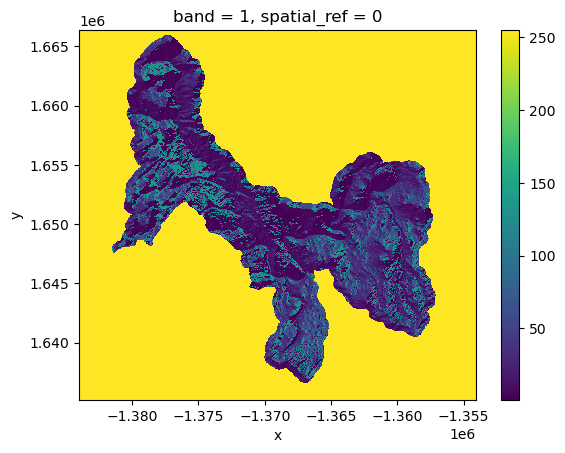

In [17]:
%%time
us_fdr = utilities.intake_raster(us_fdr_tif)
us_fdr.plot()

### Get the upstrean basin shapefile as a `geopandas.GeoDataFrame`

In [18]:
us_basin_shp = gpd.read_file(us_basin_shp_path)
us_basin_shp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,GNIS_ID,Name,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,0,Honey Draw-Colorado River,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-111.45208 36.90750, -111.45209 36.9..."
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,0,Johnson Point-Paria River,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-111.69386 37.00586, -111.69386 37.0..."


## Import a 12 month DAYMET precipitation raster from THREDDS using our AOI
**Note:** Here we use [`pydaymet`](https://hyriver.readthedocs.io/en/latest/autoapi/pydaymet/pydaymet/index.html) to read Daymet data directly into a `xr.DataSet`. We then query only for precipitation (`variable='prcp')` to get a `xr.DataArray`.

In [19]:
bounding_box = list(us_basin_shp.geometry.total_bounds)
print(f'Boudning box: {bounding_box}')

Boudning box: [-111.71574357557677, 36.771840865839465, -111.43463711872147, 37.00637998943375]


In [22]:
import pydaymet
daymet_precip = pydaymet.get_bygeom(bounding_box,
                                  crs=us_basin_shp.crs.to_wkt(),
                                  dates=("2021-01-01", "2021-12-30"),
                                  variables='prcp',
                                  time_scale="monthly"
                                 )['prcp']

In [26]:
daymet_precip

<xarray.DataArray 'prcp' (time: 12, y: 28, x: 28)>
dask.array<getitem, shape=(12, 28, 28), dtype=float32, chunksize=(12, 28, 28), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 2021-01-16T12:00:00 ... 20...
  * y                        (y) float32 -513.0 -514.0 -515.0 ... -539.0 -540.0
  * x                        (x) float32 -1e+03 -999.2 -998.2 ... -974.2 -973.2
    lambert_conformal_conic  int32 0
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    units:         mm
    long_name:     monthly total precipitation
    _ChunkSizes:   [ 10 300 300]

### Visualize the Daymet precipitation data

Net AOI precipitation over time


(array([2228., 1634., 1078.,  459.,  298.,  407.,  625.,  272.,  162.,
          37.]),
 array([ 0.        ,  5.42600012, 10.85200024, 16.27799988, 21.70400047,
        27.13000107, 32.55599976, 37.98200226, 43.40800095, 48.83400345,
        54.26000214]),
 <BarContainer object of 10 artists>)

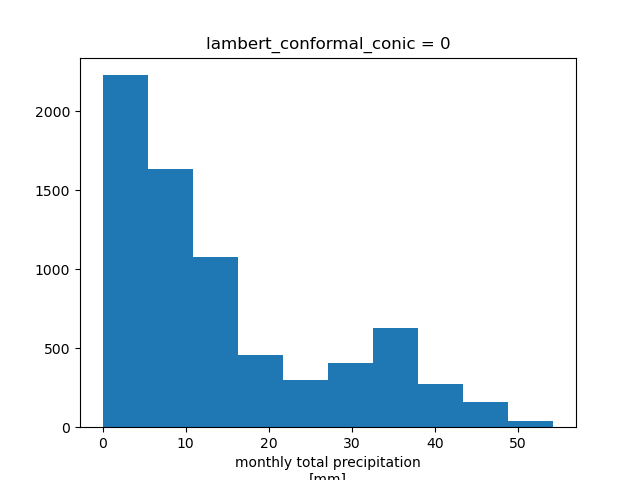

In [31]:
%matplotlib widget
print('Net AOI precipitation over time')
daymet_precip.plot()

Visualizing January precipitation:


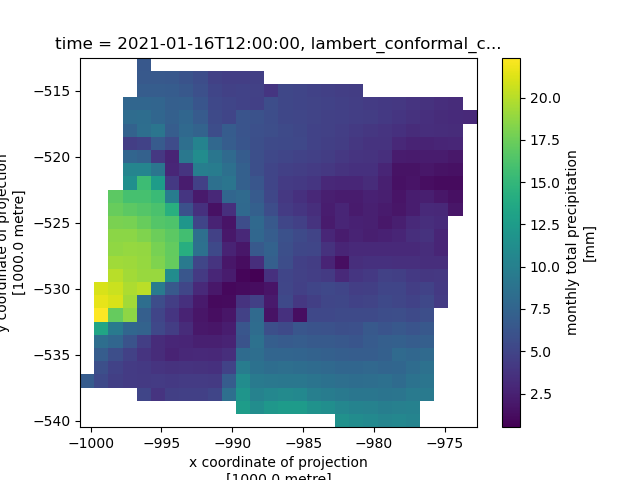

In [30]:
%matplotlib widget
print('Visualizing January precipitation:')
daymet_precip.isel(time=0).plot()

# Make a Flow Accumulation Cell (FAC) raster from a Flow Direction Raster (FDR)
**Note:** The v2 versino of FCPGTools supports multiple "geoprocessing engines" which can be used interchangably. **In this demo we use [`pysheds`](http://mattbartos.com/pysheds/), although legacy TauDEM support is also possible.**

## Make a stream mask raster based on a cell accumulation threshold

# Prepare parameter grids

## Clip, reproject, and resample (one-by-one)

## Or align parameter grid to the FDR in one line

# Make a parameter grid FAC raster

# Create a multi-dimensional Flow Conditioned Parameter Grid (FCPG)

# Compare with V1 implementation